In [ ]:
%%capture
!pip install dynamiqs

In [ ]:
import dynamiqs as dq
import jax
import jax.numpy as jnp
from scipy import constants
import matplotlib.pyplot as plt

## 2. Simulate the dynamics of cat qubits at the circuit level.

When simulating a quantum system at the circuit level, the system becomes a bit more complex.
In Tutorial 2, we have seen that ATS with a flux pump can be used to engineer the two-photon interaction, let's simulate this in practice:

For this, consider the Lindblad master equation:

$$\frac{d \hat{\rho}}{dt} = \mathcal{L}[\hat{\rho}] = -i \left[\hat{H}, \hat{\rho}\right] + \kappa_b \mathcal{D}(\hat{b})[\hat{\rho}] +  \kappa_a \mathcal{D}(\hat{a})[\hat{\rho}]$$

At the saddle point ($\varphi_\Sigma = \pi/2 + \epsilon(t)$, $\varphi_\Delta = \pi/2$) the Hamiltonian of the system in the lab frame is given by
```math
\begin{aligned}
\hat{H} &= \hat{H}_0 + \hat{H}_{\mathrm{ATS}} + \hat{H}_d,\qquad \mathrm{with}\\
\hat{H}_0 &= \omega_{a,0}\hat{a}^\dagger \hat{a} + \omega_{b,0} \hat{b}^\dagger \hat{b}\\
\hat{H}_{ATS} &= -2 E_J \sin(\epsilon(t)) \sin(\hat{\varphi}) +2 \Delta E_J \cos(\epsilon(t)) \cos(\hat{\varphi}),\\
\hat{H}_d &= 2 \epsilon_d \cos(\omega_d t) \left(\hat{b} +  \hat{b}^\dagger\right).
\end{aligned}
```

Here, $\epsilon(t) = \epsilon_p \cos(\omega_p t)$.

**Task 2.1: Lab frame simulation**

Using `dynamiqs`, simulate the time-evolution of this system with the following parameters (taken [from this paper](https://arxiv.org/abs/2307.06617)):

\begin{aligned}
\omega_{a,0}/2\pi &= 5.26\; \mathrm{GHz}\\
\omega_{b,0}/2\pi &= 7.70\; \mathrm{GHz}\\
\varphi_a &= 0.06\\
\varphi_b &= 0.29\\
E_J/h &= 42.76\; \mathrm{GHz}\\
\Delta E_J / h &= 0.47\;\mathrm{GHz}\\
\omega_d/2\pi &= 7.623 \; \mathrm{GHz}\\
\omega_p/2\pi &= 2.891 \; \mathrm{GHz}\\
\epsilon_d/2\pi &= -3.815 \; \mathrm{MHz}\\
\epsilon_p &= 0.122 \; \mathrm{rad}
\end{aligned}


Starting from the vacuum in both modes, simulate the dynamics of this system for a time $T = X \; \mu \mathrm{s}$.
Plot the evolution of the wigner function in mode a.



In [ ]:
# Parameters (converted to angular frequencies)
omega_a = 5.26 * 2 * jnp.pi  # GHz to rad/μs
omega_b = 7.70 * 2 * jnp.pi
phi_a = 0.06
phi_b = 0.29
E_J = 42.76 * constants.h
Delta_E_J = 0.47 * constants.h
omega_d = 7.623 * 2 * jnp.pi
omega_p = 2.891 * 2 * jnp.pi
epsilon_d = -3.815 * 1e-3 * 2 * jnp.pi  # MHz to rad/μs
epsilon_p = 0.122  # rad

In [ ]:
T = 4.0  # μs
num_steps = 1000
tsave = jnp.linspace(0, T, num_steps)

# Hilbert space dimensions
N_a = 30  # Mode a truncation
N_b = 7  # Mode b truncation

# Quantum operators
a = dq.tensor(dq.destroy(N_a), dq.eye(N_b))  # Correct tensor product
b = dq.tensor(dq.eye(N_a), dq.destroy(N_b))  # Correct tensor product
a_dag = dq.tensor(dq.destroy(N_a).dag(), dq.eye(N_b))  # Explicit Hermitian conjugate
b_dag = dq.tensor(dq.eye(N_a), dq.destroy(N_b).dag())  # Explicit Hermitian conjugate

# Time-dependent ATS Hamiltonian
def H_total(t):
    # Static Hamiltonian components
    H0 = (
        omega_a * (a_dag @ a) +
        omega_b * (b_dag @ b)
    )

    eps_t = epsilon_p * jnp.cos(omega_p * t)

    # Construct phi_hat with proper tensor structure
    phi_op = (
        phi_a * (a + a_dag) +
        phi_b * (b + b_dag)
    )

    # Convert to JAX array and compute trigonometric terms
    phi_delta = jnp.pi/2
    phi_jax = dq.to_jax(phi_op)
    sin_term = dq.asqarray(jnp.sin(phi_jax), (N_a,N_b))
    cos_term = dq.asqarray(jnp.cos(phi_jax), (N_a,N_b))

    H_ATS = (
        -2 * E_J * jnp.sin(eps_t) * sin_term +
        2 * Delta_E_J * jnp.cos(eps_t) * cos_term
    )

    drive_term = 2 * epsilon_d * jnp.cos(omega_d * t)
    H_d = drive_term * (b + b_dag)

    return dq.asqarray(H0 + H_ATS + H_d)

# Convert to TimeQarray
H_total_tq = dq.timecallable(H_total)

# Dissipation operators (already properly tensored)
kappa_a = 9.3 * omega_a / (2 * jnp.pi)
kappa_b = 2.6 * omega_b / (2 * jnp.pi)
L_a = jnp.sqrt(kappa_a) * a
L_b = jnp.sqrt(kappa_b) * b

# Initial state (vacuum)
rho0 = dq.tensor(dq.fock_dm(N_a, 0), dq.fock_dm(N_b, 0))

# Solve the master equation
result = dq.mesolve(H_total_tq, [L_a, L_b], rho0, tsave)

<ipython-input-4-c33113c65198>:45: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return dq.asqarray(H0 + H_ATS + H_d)
/usr/local/lib/python3.11/dist-packages/dynamiqs/qarrays/qarray.py:481: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return self.__add__(y)


|██████████| 100.0% ◆ elapsed 02m13s ◆ remaining 0.00ms


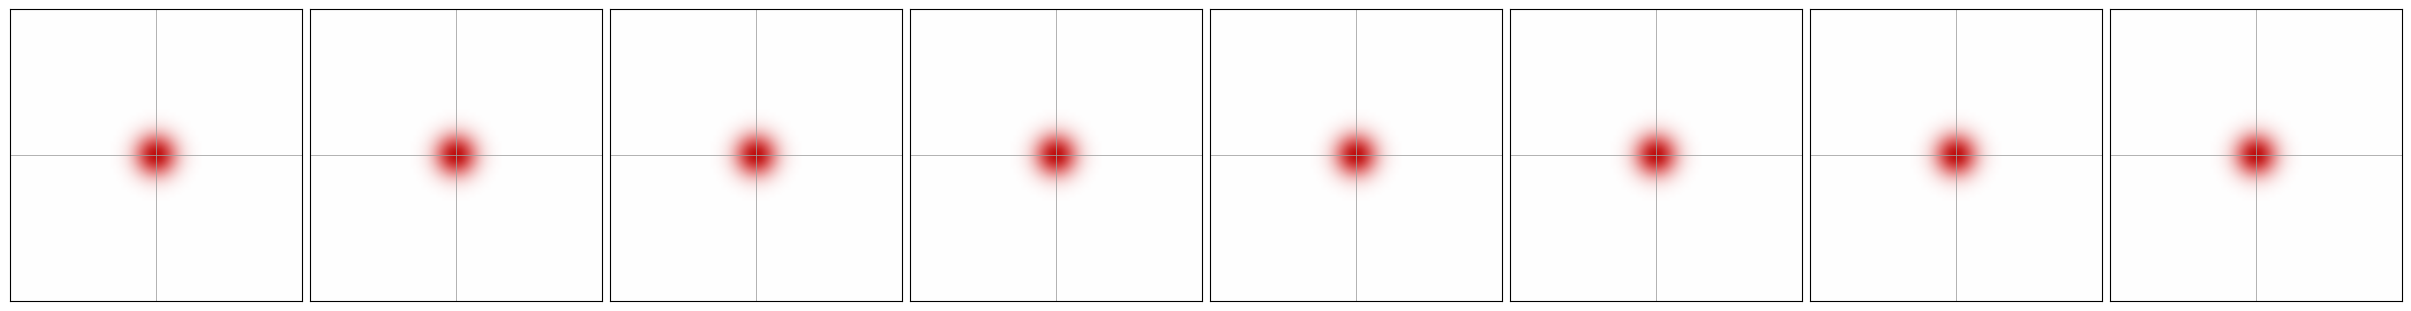

In [ ]:
dq.plot.wigner_mosaic(dq.ptrace(result.states, 0, (N_a, N_b)), cross = True)

We tried to apply the correct formula to present a wigner diagram. We suspect that our problem was about the time-dependency issue such that it seems to be stationery throughout the whole process

**Task 2.2: Rotated-displaced frame simulation**

To compare with the system at the effective Hamiltonian level, we have to transform our circuit level system into a rotated-displaced frame.
Find the correct rotated-displaced frame for the system.

Then, simulate the time-evolution of this system with the previous parameters.

Plot again the evolution of the wigner funciton in mode a. What is different in this frame?


In [ ]:
import numpy as np

#initialization:
delta_a, delta_b = (0.0,0.0) # set initial AC Stark shifts to zero
omega_p = 2*omega_a - omega_b # initial frequency matching condition

#recursion loop to compute AC Stark shift:
rec_depth = 30
for i in range(rec_depth):
    #compute xi for mode a and b:
    alpha_1 = 1j*E_J*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a - omega_p))
    alpha_2 = 1j*E_J*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a + omega_p))

    beta_1 = 1j*E_J*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b - omega_p))
    beta_2 = 1j*E_J*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b + omega_p))

    pre = (np.real(alpha_1) + np.real(alpha_2)) * phi_a \
    + (np.real(beta_1) + np.real(beta_2)) * phi_b
    #compute AC Stark shifts:
    delta_a = 1/3*E_J * epsilon_p * phi_a**2 * pre
    delta_b = 1/3*E_J * epsilon_p * phi_b**2 * pre

    #recompute frequencies
    omega_a = omega_a - 2*Delta_E_J*phi_a**2 + delta_a
    omega_b = omega_b - 2*Delta_E_J*phi_b**2 + delta_b
    omega_p = 2*omega_a - omega_b

omega_d = omega_b

In [ ]:
#Fock-space dimension in the memory mode:
n_fock_a = 30
#Fock-space dimension in the buffer mode:
n_fock_b = 7

#annihilation operators:
a, b = dq.destroy(n_fock_a, n_fock_b)

#identity operator:
identity = dq.tensor(dq.eye(n_fock_a), dq.eye(n_fock_b))

In [ ]:
# define the ATS driving term
eps_ats = lambda t: epsilon_p*jnp.cos(omega_p*t)
def op_rot_displaced(t, op, omega_rot, dis):
    return op*jnp.exp(-1j*omega_rot*t) + dis * identity

In [ ]:
def hamiltonian_rotating_displaced(t):

    #compute displacement fields
    alpha_t = alpha_1*jnp.exp(-1j*omega_p*t) + alpha_2*jnp.exp(1j*omega_p*t)
    beta_t = beta_1*jnp.exp(-1j*omega_p*t) + beta_2*jnp.exp(1j*omega_p*t)


    # the displaced rotating frame introduces a drive and detuning
    d_alpha_t = 1j*omega_p * (alpha_2*jnp.exp(1j*omega_p*t) - alpha_1*jnp.exp(-1j*omega_p*t))
    d_beta_t = 1j*omega_p * (beta_2*jnp.exp(1j*omega_p*t) - beta_1*jnp.exp(-1j*omega_p*t))


    #compute rotated displaced operators:
    a_f = op_rot_displaced(t, a, omega_a, d_alpha_t)
    b_f = op_rot_displaced(t, b, omega_b, d_beta_t)
    bdag_f = op_rot_displaced(t, b.dag(), omega_b, d_beta_t)
    adag_f = op_rot_displaced(t, a.dag(), omega_a, d_alpha_t)

    #rot matrix

    omega_rot_a = 2*omega_a - omega_b
    omega_rot_b = 2*omega_b - omega_a

    #displaced rotated phase operator
    phi_f = phi_a*(a_f + adag_f) + phi_b*(b_f + bdag_f)

    #linear term
    h_0 = omega_a * adag_f @ a_f + omega_b * bdag_f @ b_f

    #term from derivative of rotating frame
    h_rot = - omega_rot_a * dq.dag(a) @ a  - omega_rot_b * dq.dag(b) @ b

    #term from derivative of displaced frame
    h_dis =  -1j*(d_alpha_t*dq.dag(a)*jnp.exp(1j*omega_rot_a*t)-jnp.conj(d_alpha_t)*a*jnp.exp(-1j*omega_rot_a*t)) \
      - 1j*(d_beta_t*dq.dag(b)*jnp.exp(1j*omega_rot_b*t)-jnp.conj(d_beta_t)*b*jnp.exp(-1j*omega_rot_b*t))


    #ats term:
    sinterm = jnp.sin(eps_ats(t)) * dq.sinm(phi_f)
    costerm = jnp.cos(eps_ats(t)) * dq.cosm(phi_f)
    h_ats = - 2*E_J*sinterm +  2*Delta_E_J*costerm

    #drive on the buffer:
    # in the rotating frame, this term is non-rotating
    h_buffer_drive = jnp.conj(epsilon_d)*jnp.exp(1j*omega_d*t)*b_f \
        + epsilon_d * jnp.exp(-1j*omega_d*t) * bdag_f

    return h_0 + h_ats + h_buffer_drive + h_rot + h_dis



In [ ]:
kappa_a = 9.3 * omega_a / (2 * jnp.pi)
kappa_b = 2.6 * omega_b / (2 * jnp.pi)
L_a = jnp.sqrt(kappa_a) * a
L_b = jnp.sqrt(kappa_b) * b

# Initial state (vacuum)
rho0 = dq.tensor(dq.fock_dm(N_a, 0), dq.fock_dm(N_b, 0))

# Solve the master equation
result1 = dq.mesolve(hamiltonian_rotating_displaced(0), [L_a, L_b], rho0, tsave)

/usr/local/lib/python3.11/dist-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
<ipython-input-10-8f0ebfa767bb>:48: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return h_0 + h_ats + h_buffer_drive + h_rot + h_dis
/usr/local/lib/python3.11/dist-packages/dynamiqs/qarrays/qarray.py:481: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return self.__add__(y)
|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

|██████████| 100.0% ◆ elapsed 14.27s ◆ remaining 0.00ms


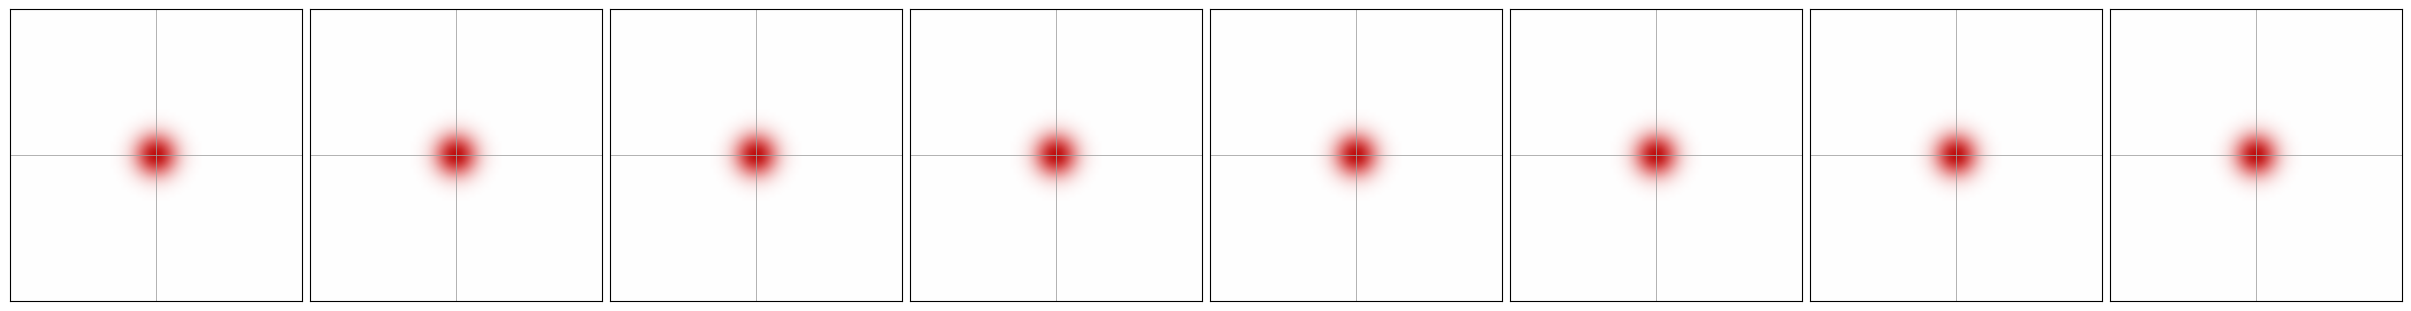

In [ ]:
dq.plot.wigner_mosaic(dq.ptrace(result1.states, 0, (N_a, N_b)), cross = True)

Same issue with 2.2 even though we have used the hint. Time dependency is the critical spectrum that we didn't hit that accurately. I think if we have more time we can solve this task, but we gotta slee